# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

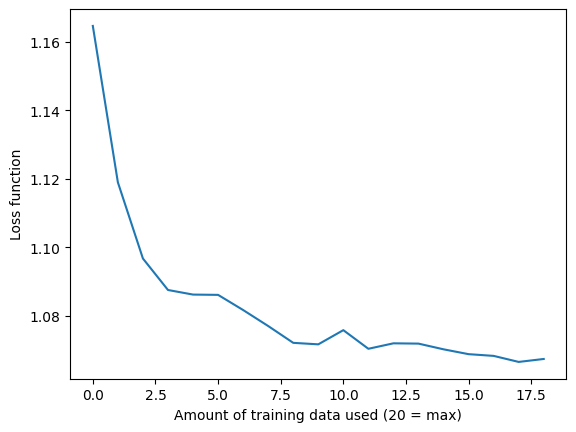

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

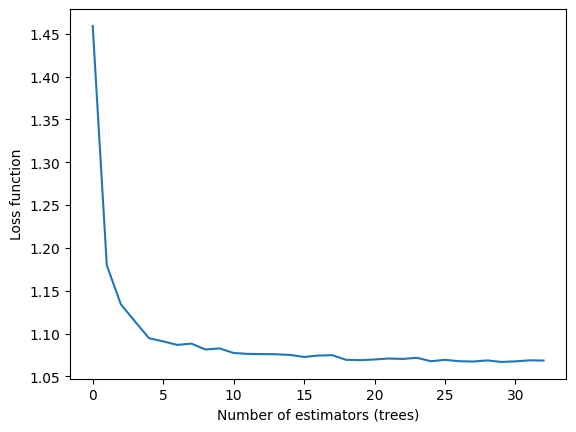

In [6]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [12]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [13]:
# Extract files and using "cca" to distinct from other datasets 
zip_file_path_cca = "cc_approval.zip"  
extracted_dir_cca = "extracted_data_cca"

os.makedirs(extracted_dir_cca, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path_cca, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_cca)
    print(f"Successfully unzipped '{zip_file_path_cca}' to '{extracted_dir_cca}'")

    # List contents
    print(f"\nContents of '{extracted_dir_cca}':")
    for item in os.listdir(extracted_dir_cca):
        print(f"- {item}")

except FileNotFoundError:
    print(f"Error: The file '{zip_file_path_cca}' was not found. Check the path.")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path_cca}' is not a valid ZIP file or is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully unzipped 'cc_approval.zip' to 'extracted_data_cca'

Contents of 'extracted_data_cca':
- Application_Data.csv


In [14]:
csv_file_name_cca = "Application_Data.csv"
full_csv_path_cca = os.path.join(extracted_dir_cca, csv_file_name_cca)

df_cca = pd.read_csv(full_csv_path_cca)

In [16]:
# Data Preprocessing
target_col = 'Status'
feature_cols = [col for col in df_cca.columns if col != target_col]

# Remove rows where target is missing
df_model = df_cca[feature_cols + [target_col]].dropna(subset=[target_col])

# Split features and target
X = df_model[feature_cols]
y = df_model[target_col]

# Identify column types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


In [17]:
# Final pipeline with random forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Hyperparameter space
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
search.fit(X_train, y_train)

# Evaluate
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best parameters:", search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': None}
R² Score: 0.9085710072994505
RMSE: 0.021691578628372288


# Reflection
I implemented a Random Forest regressor to predict loan amounts based on a variety of application features. I used RandomizedSearchCV for hyperparameter tuning and evaluated the model using R² and RMSE. I learned that the max_depth and n_estimators parameters greatly affect model performance. I also experimented with pipeline preprocessing, which simplifies handling of both numeric and categorical data.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

/tmp/ipykernel_18300/2344253461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${int(tick)}' for tick in ax.get_yticks()])


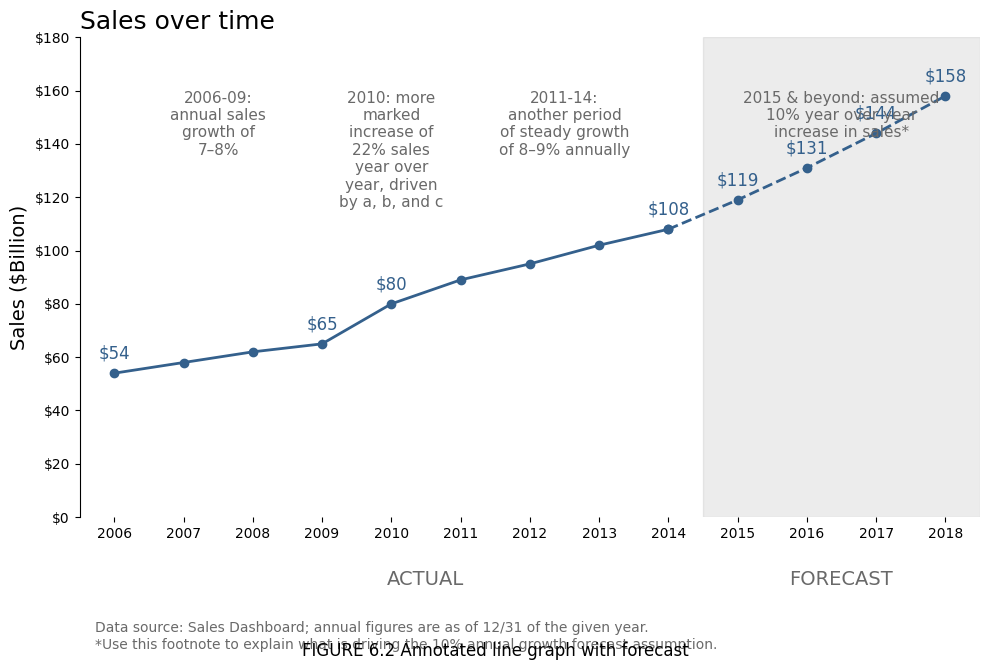

In [19]:
# There is no graphs in chapter seven so I will replicate one from chapter 6 again.

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Data for the plot
years_actual = np.array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
sales_actual = np.array([54, 58, 62, 65, 80, 89, 95, 102, 108])
years_forecast = np.array([2014, 2015, 2016, 2017, 2018])
sales_forecast = np.array([108, 119, 131, 144, 158])

# Plotting the data
ax.plot(years_actual, sales_actual, color='#34608c', linewidth=2, marker='o', markersize=6)
ax.plot(years_forecast, sales_forecast, color='#34608c', linewidth=2, linestyle='--', marker='o', markersize=6)

# Adding key annotations and text
actual_points_to_label = {2006: 54, 2009: 65, 2010: 80, 2014: 108}
for year, sale in actual_points_to_label.items():
    ax.text(year, sale + 4, f'${sale}', ha='center', va='bottom', fontsize=12, color='#34608c')
forecast_points_to_label = {2015: 119, 2016: 131, 2017: 144, 2018: 158}
for year, sale in forecast_points_to_label.items():
    ax.text(year, sale + 4, f'${sale}', ha='center', va='bottom', fontsize=12, color='#34608c')

# Shading and labels for "ACTUAL" and "FORECAST"
ax.axvspan(2014.5, 2018.5, color='gray', alpha=0.15)
ax.text(2010.5, -20, 'ACTUAL', ha='center', va='top', fontsize=14, color='dimgray')
ax.text(2016.5, -20, 'FORECAST', ha='center', va='top', fontsize=14, color='dimgray')

# Adding period descriptions
ax.text(2007.5, 160, '2006-09:\nannual sales\ngrowth of\n7–8%', ha='center', va='top', fontsize=11, color='dimgray')
ax.text(2010, 160, '2010: more\nmarked\nincrease of\n22% sales\nyear over\nyear, driven\nby a, b, and c', ha='center', va='top', fontsize=11, color='dimgray')
ax.text(2012.5, 160, '2011-14:\nanother period\nof steady growth\nof 8–9% annually', ha='center', va='top', fontsize=11, color='dimgray')
ax.text(2016.5, 160, '2015 & beyond: assumed\n10% year over year\nincrease in sales*', ha='center', va='top', fontsize=11, color='dimgray')

# General plot formatting
ax.set_title('Sales over time', loc='left', fontsize=18)
ax.set_ylabel('Sales ($Billion)', fontsize=14)
ax.set_ylim(0, 180)
ax.set_xlim(2005.5, 2018.5)
ax.set_xticks(np.arange(2006, 2019, 1))
ax.set_yticklabels([f'${int(tick)}' for tick in ax.get_yticks()])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.text(0.1, 0.04, 'Data source: Sales Dashboard; annual figures are as of 12/31 of the given year.', fontsize=10, color='dimgray')
fig.text(0.1, 0.015, '*Use this footnote to explain what is driving the 10% annual growth forecast assumption.', fontsize=10, color='dimgray')
fig.text(0.5, 0.0, 'FIGURE 6.2 Annotated line graph with forecast', ha='center', va='bottom', fontsize=12, color='black')
plt.tight_layout(rect=[0, 0.07, 1, 0.95]) 
plt.show()